# Lab 10.9.3: Convolutional Neural Networks

## Attribution
This notebook follows lab 10.9.3 from ISLRv2. The R-code has been ported to Python by Daniel Kapitan (08-01-2022).


## Data preparation
In this section we fit a CNN to the [CIFAR100 data](https://keras.io/api/datasets/cifar100/), which is available in the [Keras](https://keras.io) package. It is arranged in a similar fashion as the MNIST data.

In [1]:
import os
import pickle
from pprint import pprint
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'


import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

%matplotlib inline

# load the data
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)
print(f"Range of values train matrix: {X_train.min()} ... {X_train.max()}")

Train matrix shape (50000, 32, 32, 3)
Test matrix shape (10000, 32, 32, 3)
Range of values train matrix: 0 ... 255


The array of 50,000 training images has four dimesnions: each three-color image is represented as a set of three channels, each of which consists of $32 \times 32$ eight-bit pixels. We standardize as we dit for the digits, but keep the array structure. We one-hot encode the response factors to produce a 100-column binary matrix.

In [2]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 100
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (50000, 1)
Shape after one-hot encoding:  (50000, 100)


Before we start, we look at some of the training images. The file `cifar100_meta` contains the label names.

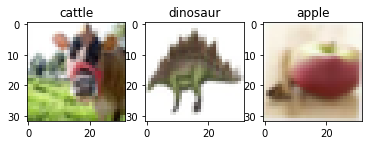

In [18]:
fig = plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[i])
    plt.title(f"{labels['fine_label_names'][y_train[i][0]]}")
fig;

## Building the network

Here we specify a moderately-sized CNN for demonstration purposes.

In [4]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape= (32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

Notice that we used the `padding = same` argument to `Conv2D()`, which ensures that the output channels have the same dimension as the input channels. There are 32 channels in the first hidden layer, in contrast to the three channels in the input layer. We use a $3 \times 3$ convolution filter for each channel in all the layers. Each convolution is followed by a max-pooling layer over $2 \times 2$ blocks. By studying the summary, we can see that the channels halve in both dimensions after each of the max-pooling operations. After the last of these we have a layer with 256 channels of dimension $2 \times 2$. These are then flattened to a dense layer of size 1,024: in other words, each of the $2 \times 2$ matrics is turned into a 4-vector, and put side-by-side in one layer. This is followed by a dropout regularization layer, then another dense layers of size 512, which finally reaches the softmax output layer.

## Compiling and training the Model

Finally, we specify the fitting algorithm, and fit the model.

In [5]:
%%time
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=30, validation_split=0.2)

# save the model
model_name = 'keras_cifar100.h5'
model.save(model_name)
print(f'Saved trained model at {model_name}')

Epoch 1/30
313/313 [==============================] - 21s 67ms/step - loss: 4.1307 - accuracy: 0.0610 - val_loss: 3.7441 - val_accuracy: 0.1196
Epoch 2/30
313/313 [==============================] - 20s 65ms/step - loss: 3.4793 - accuracy: 0.1650 - val_loss: 3.2364 - val_accuracy: 0.2169
Epoch 3/30
313/313 [==============================] - 20s 64ms/step - loss: 3.1171 - accuracy: 0.2275 - val_loss: 3.0188 - val_accuracy: 0.2521
Epoch 4/30
313/313 [==============================] - 20s 65ms/step - loss: 2.8494 - accuracy: 0.2817 - val_loss: 2.7353 - val_accuracy: 0.3050
Epoch 5/30
313/313 [==============================] - 20s 65ms/step - loss: 2.6497 - accuracy: 0.3214 - val_loss: 2.6284 - val_accuracy: 0.3348
Epoch 6/30
313/313 [==============================] - 21s 66ms/step - loss: 2.4713 - accuracy: 0.3557 - val_loss: 2.4881 - val_accuracy: 0.3620
Epoch 7/30
313/313 [==============================] - 21s 67ms/step - loss: 2.3206 - accuracy: 0.3883 - val_loss: 2.4010 - val_accuracy:

In [6]:
# plotting the metrics
_ = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={"index": "epoch"})
    .assign(epoch=lambda df: df.epoch + 1)
)
df = pd.concat(
    [
        _.iloc[:, 0:3].assign(fold="training"),
        _.iloc[:, [0, -2, -1]]
        .rename(columns={"val_accuracy": "accuracy", "val_loss": "loss"})
        .assign(fold="validation"),
    ],
    axis=0,
).reset_index(drop=True)
base = alt.Chart(df).mark_line(point=True)
loss = base.encode(x="epoch:Q", y="loss", color="fold", tooltip=["epoch", alt.Tooltip("loss", format=",.2f")])
accuracy = base.encode(x="epoch:Q", y="accuracy", color="fold", tooltip=["epoch", alt.Tooltip("accuracy", format=",.2f")] )
loss | accuracy

alt.HConcatChart(...)

This model takes 10 minutes to run and achieves 46% accuracy on the test data. Although this is not terrible for 100-class data (a random classifier gets 1% accuracy), searching the web we see results around 75%. Typically, it takes a lot of architecture carpentry, fiddling with regularization, and time to achieve such results.

In [19]:
loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {loss_and_metrics[0]:.3f}")
print(f"Test Accuracy: {loss_and_metrics[1]:.3f}")

313/313 - 2s - loss: 2.4390 - accuracy: 0.4524 - 2s/epoch - 6ms/step
Test Loss: 2.439
Test Accuracy: 0.452
